<span style="color: green;">

# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

</span>


I worked with papavero.dinfo.unifi.it and I have installed the needed packages with the following commands:

```

conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia
pip install -U scikit-learn
pip install matplotlib

```


### Import


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    classification_report,
    accuracy_score,
)

### Device


In [2]:
i = 0
if torch.cuda.is_available():
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # yes, I have a MacBookPro with M1 Pro
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

device: cuda:0
GPU: NVIDIA RTX A2000 12GB


<span style="color: green;">

## Exercise 1: OOD Detection and Performance Evaluation

In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

</span>


<span style="color: green;">

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

- CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are _not_ in CIFAR-10 (see `torch.utils.data.Subset`).
- Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
- Something else, but if using images keep the images reasonably small!

In this exercise your _OOD Detector_ should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

</span>


### Iperparametri


In [3]:
batch_size = 1
epochs = 20
lr = 0.01
val_size = 10000
epochs = 50

Le funzioni della cella hannno lo scopo di capire come sono distribuite le label del dataset preso in considerazione e calcolare i valori per normalizzare le immagini.


In [4]:
# plot label distribution with string


def plot_hist_labels_distribution_string(data, num_classes, split, position):
    if split == "train":
        labels_train = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_train)]).float()
        classes = data.dataset.classes
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
        classes = data.dataset.classes
    elif split == "test":
        all_labels = torch.tensor([value for value in list(data.targets)]).float()
        classes = data.classes

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    if num_classes <= 10:
        plt.xticks(np.arange(0, num_classes, 1), classes, rotation=90)
    plt.title(split + " " + "Set Label Distribution")


# for mnist: get_normalize_values(ds_train_initial.data.float())
# for cifar10: get_normalize_values(ds_train_initial.data)


def get_normalize_values(data):
    return (
        data.mean(axis=(0, 1, 2)) / 255,
        data.std(axis=(0, 1, 2)) / 255,
    )

## Dataset In-Distribution (cifar-10)


Files already downloaded and verified
Files already downloaded and verified
Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
N° samples train: 40000
N° samples validation: 10000
N° samples test: 10000
N° batches train: 40000
N° batches val: 10000
N° batches test: 10000


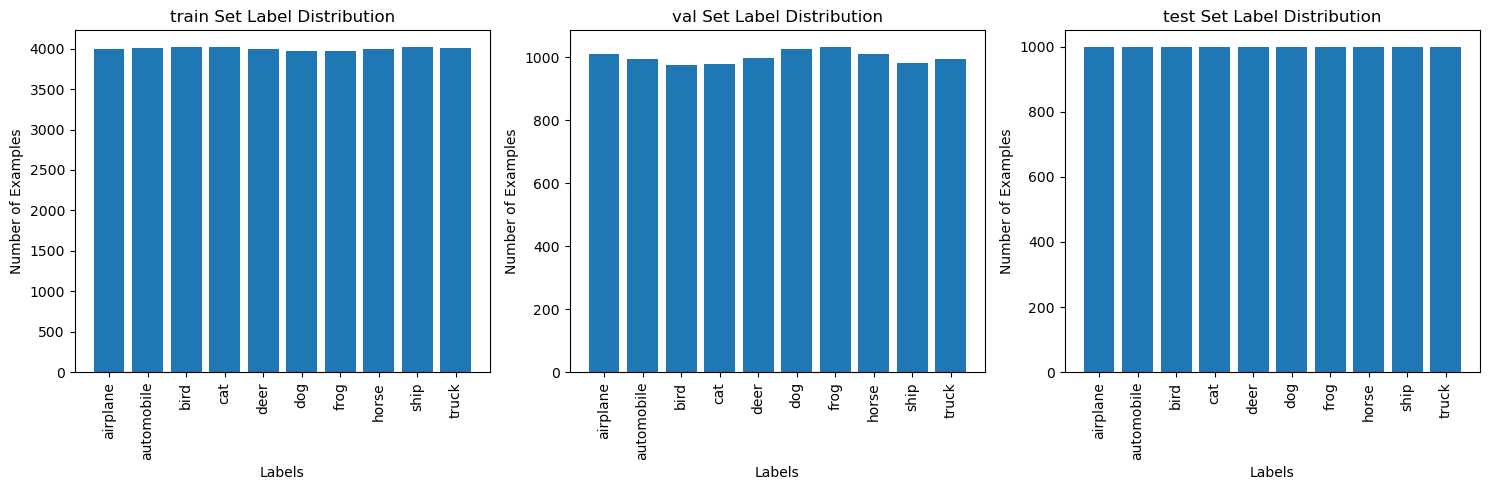

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091),
            (0.24703223, 0.24348513, 0.26158784),
        ),
    ]
)

ds_train_initial = CIFAR10(
    root="../dataset/", train=True, download=True, transform=transform
)
num_classes = len(ds_train_initial.classes)
id_ds_test = CIFAR10(
    root="../dataset/", train=False, download=True, transform=transform
)

n_examples_test = len(id_ds_test)
print(f"Classes: {ds_train_initial.class_to_idx}")

I = np.random.permutation(len(ds_train_initial))
id_ds_val = Subset(ds_train_initial, I[:val_size])
n_examples_val = len(id_ds_val)

id_ds_train = Subset(ds_train_initial, I[val_size:])
n_examples_train = len(id_ds_train)

print(f"N° samples train: {n_examples_train}")
print(f"N° samples validation: {n_examples_val}")
print(f"N° samples test: {n_examples_test}")
# Imposta la dimensione della figura per contenere i 3 grafici in riga

plt.figure(figsize=(15, 5))

plot_hist_labels_distribution_string(id_ds_train, num_classes, "train", 1)
plot_hist_labels_distribution_string(id_ds_val, num_classes, "val", 2)
plot_hist_labels_distribution_string(id_ds_test, num_classes, "test", 3)

plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

id_dl_train = torch.utils.data.DataLoader(
    id_ds_train, batch_size, shuffle=True, num_workers=4
)
id_dl_val = torch.utils.data.DataLoader(id_ds_val, batch_size, num_workers=4)
id_dl_test = torch.utils.data.DataLoader(
    id_ds_test, batch_size, shuffle=False, num_workers=4
)

num_batch_train = len(id_dl_train)
num_batch_val = len(id_dl_val)
num_batch_test = len(id_dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

id_classes = ds_train_initial.classes

id2label = {v: k for k, v in ds_train_initial.class_to_idx.items()}

## Dataset Out-of-Distribution (cifar100)


Files already downloaded and verified
Classes: {'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'r

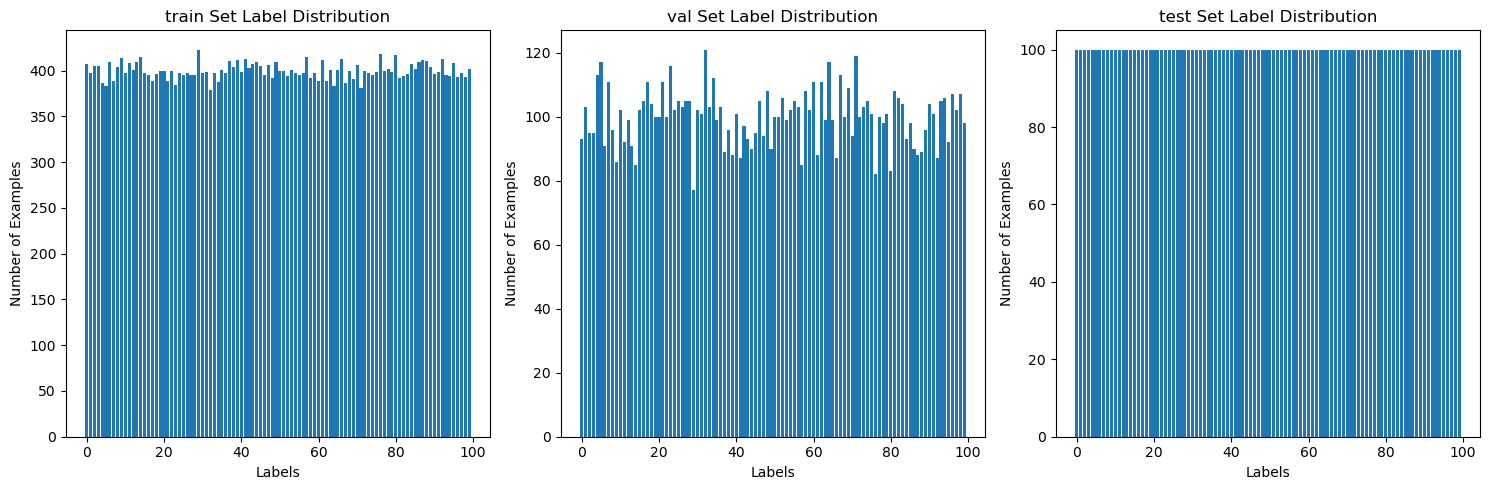

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.50707516, 0.48654887, 0.44091784),
            (0.26733429, 0.25643846, 0.27615047),
        ),
    ]
)

ds_train_initial = CIFAR100(
    root="../dataset/", train=True, download=True, transform=transform
)
num_classes = len(ds_train_initial.classes)
ood_ds_test = CIFAR100(
    root="../dataset/", train=False, download=False, transform=transform
)

n_examples_test = len(ood_ds_test)

print(f"Classes: {ds_train_initial.class_to_idx}")

I = np.random.permutation(len(ds_train_initial))
ood_ds_val = Subset(ds_train_initial, I[:val_size])
n_examples_val = len(ood_ds_val)

ood_ds_train = Subset(ds_train_initial, I[val_size:])
n_examples_train = len(ood_ds_train)

print(f"N° samples train: {n_examples_train}")
print(f"N° samples validation: {n_examples_val}")
print(f"N° samples test: {n_examples_test}")
# Imposta la dimensione della figura per contenere i 3 grafici in riga

plt.figure(figsize=(15, 5))

plot_hist_labels_distribution_string(ood_ds_train, num_classes, "train", 1)
plot_hist_labels_distribution_string(ood_ds_val, num_classes, "val", 2)
plot_hist_labels_distribution_string(ood_ds_test, num_classes, "test", 3)

plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

ood_dl_train = torch.utils.data.DataLoader(
    ood_ds_train, batch_size, shuffle=True, num_workers=4
)
ood_dl_val = torch.utils.data.DataLoader(ood_ds_val, batch_size, num_workers=4)
ood_dl_test = torch.utils.data.DataLoader(
    ood_ds_test, batch_size, shuffle=False, num_workers=4
)

num_batch_train = len(ood_dl_train)
num_batch_val = len(ood_dl_val)
num_batch_test = len(ood_dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

ood_classes = ds_train_initial.classes

In [7]:
# prendi le classi di cifar100 che non sono in cifar10
# print(id_classes + ood_classes)
# print(len(set(id_classes + ood_classes)))

# You will need to wrap CIFAR-100 in some way to select a subset
# of classes that are _not_ in CIFAR-10 (see `torch.utils.data.Subset`).

# NO, cifar10 e cifar100 non hanno nessuna classe in comune

## Choose ID & OOD Dataset


L'idea è quella di eseguire l'addestramento sul dataset di train di cifar10. Dopodichè prendiamo in esame due test set: uno in-distribution (cifar10) e uno out-of-distribution (cifar100). Entrambi i test set hanno una dimensione di 10000 esempi.


In [7]:
id_train = id_dl_train  # 10 classi
in_data = id_dl_test  # 10 classi
ood_data = ood_dl_test  # 100 classi

### Model


Il modello preso in considerazione è una rete convoluzionale classica ma poco profonda. Non è importante che il modello sia complesso per fare gli esperimenti sull' OOD.


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training Loop


In [9]:
os.makedirs("./model/", exist_ok=True)
path_model = "./model/model.pth"
model = CNN().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

if not os.path.exists(path_model):
    for epoch in range(epochs):
        running_loss = 0.0
        # Iterate over all batches.
        for i, (Xs, ys) in enumerate(id_dl_train, 0):
            Xs = Xs.to(device)
            ys = ys.to(device)

            # Make a gradient step.
            optimizer.zero_grad()
            outputs = model(Xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average epoch loss.
        print(f"{epoch + 1} loss: {running_loss / len(id_dl_train):.3f}")

    print("Finished Training")

    torch.save(model.state_dict(), path_model)
else:
    print(f"Model saved on path {path_model}")

Model saved on path ./model/model.pth


### Pre-trained Model


In [10]:
model.load_state_dict(torch.load(path_model, map_location=device))
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Evaluation on IN Test Set


In [11]:
def evaluate_model(model, dl, device):
    model.eval()

    predictions = []
    gts = []
    losses = []

    with torch.no_grad():
        for xs, ys in dl:
            xs = xs.to(device)
            ys = ys.to(device)

            logits = model(xs)
            preds = torch.argmax(logits, dim=1)
            loss = F.cross_entropy(logits, ys)

            losses.append(loss.item())
            gts.append(ys.detach().cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())

    return gts, predictions, losses

In [12]:
gts, predictions, losses_val = evaluate_model(model, in_data, device=device)

loss_val = np.mean(losses_val)
val_acc = accuracy_score(np.hstack(gts), np.hstack(predictions))
report_acc = classification_report(
    np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3
)
print(f"Accuracy report on TEST:\n {report_acc}")
print(f"\nAccuracy on TEST:\n {val_acc}")

Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.610     0.359     0.452      1000
           1      0.560     0.556     0.558      1000
           2      0.352     0.297     0.322      1000
           3      0.263     0.161     0.200      1000
           4      0.278     0.287     0.282      1000
           5      0.409     0.510     0.454      1000
           6      0.485     0.577     0.527      1000
           7      0.447     0.582     0.506      1000
           8      0.438     0.795     0.565      1000
           9      0.655     0.245     0.357      1000

    accuracy                          0.437     10000
   macro avg      0.450     0.437     0.422     10000
weighted avg      0.450     0.437     0.422     10000


Accuracy on TEST:
 0.4369


Come abbiamo fatto nella lezione flipped, stampiamo gli istrogrammi dei valori dei logits. Qui in particolare si vuole come si distribuiscono i valori massimi dei logits considerando i test set IN e OUT distribution.


In [13]:
# Function to collect all logits from the model on entire dataset.
def collect_logits_np(model, dl):
    logits = []
    with torch.no_grad():
        for Xs, _ in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)


def hist_id_ood(model, in_data, ood_data):
    # Collect logits on CIFAR-10 test set (ID) and CIFAR-100 (OOD).
    logits_ID = collect_logits_np(model, in_data)
    logits_OOD = collect_logits_np(model, ood_data)
    # Plot the *distribution* of max logit outputs.
    _ = plt.hist(logits_ID.max(1), bins=100, density=True, alpha=0.5, label="ID")
    _ = plt.hist(logits_OOD.max(1), bins=100, density=True, alpha=0.5, label="OOD")
    plt.legend()

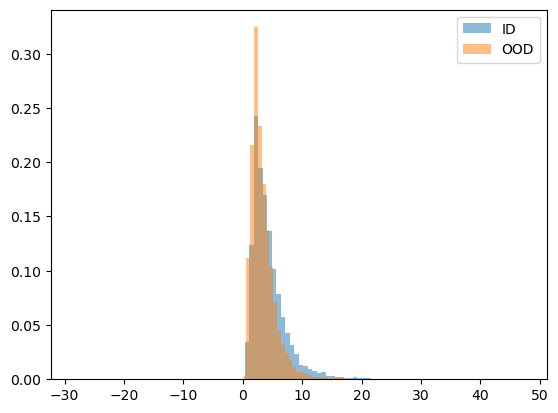

In [14]:
hist_id_ood(model, in_data, ood_data)

Le due distribuzioni sono molto sovrapposte. Questo porta ad un grave problema: se diamo in pasto alla rete un esempio OOD questo verrà classificato con una alta confidenza come un valore in distribution. Gli esperimenti successivi tentano di fornire una misura quantitativa di quanto un sistema presenta questo problema. Faremo grande uso di metrice standard di un problema di classificazione.


<span style="color: green;">

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for _both_ ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

- [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
- [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

</span>


## Area under the ROC curve for ID classification


The AUROC is calculated as the area under the ROC curve. A ROC curve shows the trade-off between true positive rate (TPR) and false positive rate (FPR) across different decision thresholds. Decision thresholds allow you to translate predicted probabilities into predicted labels. If your model outputs probabilities, you must use a decision threshold to transform those probabilities into predicted labels. AUROC is thus a performance metric for “discrimination”: it tells you about the model’s ability to discriminate between cases (positive examples) and non-cases (negative examples.)

Exemple: For a binary classification model (“1” vs. “0”), the AUROC tells you the probability that a randomly selected “1” image will have a higher predicted probability of being a “1” than a randomly selected “0” image.


In [15]:
def collect_logits(model, dl):
    logits = list()
    with torch.no_grad():
        for x, _ in dl:
            logits.append(model(x.to(device)).cpu())
    return torch.cat(logits, dim=0)  # ritorno un tensore pytorch


def prob_score(logits):
    prob = torch.softmax(logits, dim=1)
    return prob.max(dim=1).values

La cella successiva ha lo scopo di creare dei tensori torch contenenti i logits. Ho isolato questa operazione perchè è la più costosa computazionalmente in quanto ho scelto una batch size di 1.


In [16]:
logits_ID = collect_logits(model, in_data)  # len = 10K
logits_OOD = collect_logits(model, ood_data)  # len = 10K

Per fare una curva ROC è necessario avere le label ground truth (label a 1 se l'esempio è IN-distribuzione e label a 0 se l'esempio è OUT-of-distribution) e le probabilitì score.
Per ogni esempio abbiamo 10 valori di probabilità ognuno corrispondente alle classi di cifar10. Prendiamo il valore massimo e raccogliamo tali valori per il dataset ID e il dataset OOD.

Questa strategia verrà usata diffusamente anche negli esperimenti successivi per valutare una metrica di performance del nostro OOD detector.


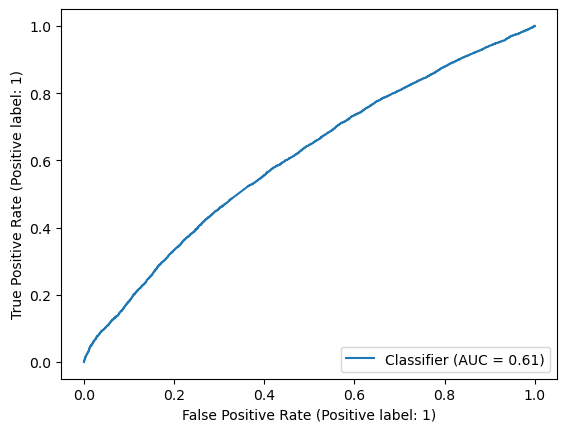

In [17]:
labels_ID = np.array([1 for _ in range(len(logits_ID))])
labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
score_prob_ID = prob_score(logits_ID)
score_prob_OOD = prob_score(logits_OOD)
pred = np.concatenate([score_prob_ID, score_prob_OOD])
RocCurveDisplay.from_predictions(y, pred)

Un'area sotto la curva ROC di 0.61 suggerisce che il modello di classificazione binaria ha una capacità di discriminazione leggermente migliore del caso di scelta casuale. Quindi al momento il nostro OOD detector non è performante a capire quali sono gli esempi ID e OOD.


## Area under the Precision-Recall curve for both ID and OOD scoring


Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive
results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision $P = \frac{T_p}{T_p+F_p}$

Recall $R = \frac{T_p}{T_p + F_n}$

These quantities are also related to the ($F_1$) score, which is defined as the harmonic mean of precision and recall
$F1 = 2\frac{P \times R}{P+R}$

The relationship between recall and precision can be observed in the stairstep area of the plot - at the edges of these steps a small change
in the threshold considerably reduces precision, with only a minor gain in recall.

**Average precision** (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

where $P_n$ and $R_n$ are the precision and recall at the nth threshold. A pair $(R_k, P_k)$ is referred to as an _operating point_.


### ID


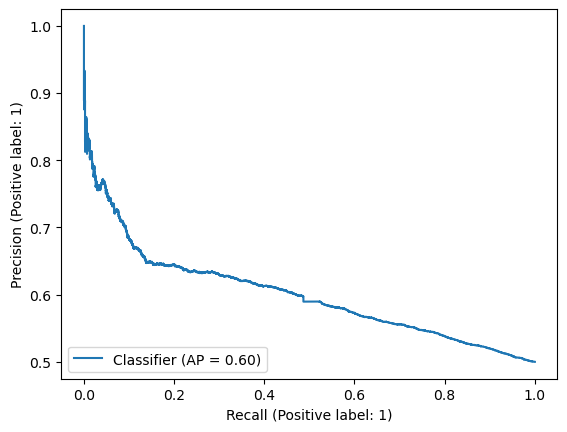

In [18]:
labels_ID = np.array([1 for _ in range(len(logits_ID))])
labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
score_prob_ID = prob_score(logits_ID)
score_prob_OOD = prob_score(logits_OOD)
pred = np.concatenate([score_prob_ID, score_prob_OOD])
PrecisionRecallDisplay.from_predictions(y, pred)

La AP è di 0.60. Le prestazioni sono moderate. Il modello ha una capacità di discriminazione, ma ci potrebbe essere spazio per miglioramenti.


### OOD


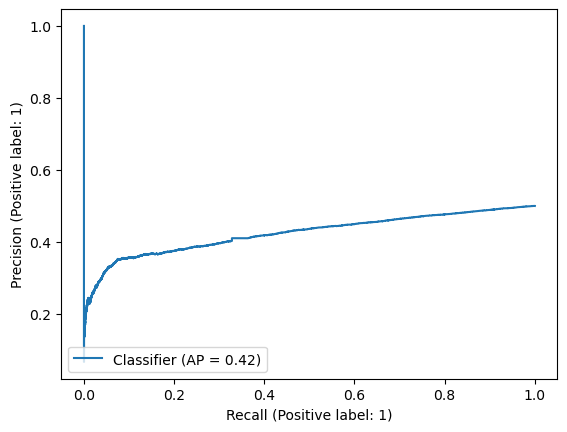

In [19]:
labels_ID = np.array([0 for _ in range(len(logits_ID))])
labels_OOD = np.array([1 for _ in range(len(logits_OOD))])
y = np.concatenate([labels_ID, labels_OOD])  # len = 20K
score_prob_ID = prob_score(logits_ID)
score_prob_OOD = prob_score(logits_OOD)
pred = np.concatenate([score_prob_ID, score_prob_OOD])
PrecisionRecallDisplay.from_predictions(y, pred)

La AP è di 0.42. Le prestazioni sono scarse, e il modello potrebbe non essere meglio di una classificazione casuale.
Questo è la prova che il nostro modello non riesce a distinguere tra ID e OOD ed è in linea con l'istogramma dei logits mostrato in precedenza.


<span style="color: green;">

---

## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla\_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

</span>


<span style="color: green;">

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation _on the fly_ so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

</span>


Pipeline svolta:

- ho un esempio
- perturbo l'esempio
- genera esempi adversarial a partire dagli esempi usati durante il training
- metti a confronto gli esempi originali con quelli adversarial
- fai il confronto muovendo epsilon


La funzione seguente ha l'obbiettivo di perturbare un'immagine di esempio. Come ultima operazione si effetta un "clipping" per mantenere l'esempio nel range 0-1.


In [20]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

La funzione denorm ha il compito di tornare all'immagine presente nel dataset prima della normalizzazione. Le immagini verranno normalizzate a seguito della perturbazione con i valori standard del datase.


In [21]:
# restores the tensors to their original scale
def denorm(
    batch,
    mean=[0.49139968, 0.48215841, 0.44653091],
    std=[0.24703223, 0.24348513, 0.26158784],
):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

La funzione "test" riporta l'accuracy di un modello che è "sotto attacco" da esempi adversarial con strength epsilon. La funzione calcola il gradiente della loss rispetto ai dati di input, crea l'immagine perturbata con la funzione fgsm attack e infine controlla se l'esempio è adversarial. Nella parte finale della funzione si cerca di restituire degli esempi che siano visualizzabili in un secondo momento in funzione dell'argomento epsilon.


In [22]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    logits = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        output_prob = torch.softmax(output, dim=1)
        # get the index of the max softmax probability
        init_pred = output_prob.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        data_denorm = denorm(data)

        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        perturbed_data_normalized = transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)
        )(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # collect logits
        logits.append(output.detach().cpu())

        # Check for success
        output_prob = torch.softmax(output, dim=1)
        final_pred = output_prob.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print(
        f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}"
    )
    logits_ID = torch.cat(logits, dim=0)

    return final_acc, adv_examples, logits_ID

Nella cella successiva si vanno a creare le metriche di performance per il nostro OOD detector: Roc curve e PR curve.


In [23]:
def roc_curve(logits_ID, logits_OOD, eps, ax):
    labels_ID = np.array([1 for _ in range(len(logits_ID))])
    labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
    y = np.concatenate([labels_ID, labels_OOD])
    score_prob_ID = prob_score(logits_ID)
    score_prob_OOD = prob_score(logits_OOD)
    pred = np.concatenate([score_prob_ID, score_prob_OOD])

    if ax is not None:
        RocCurveDisplay.from_predictions(y, pred, ax=ax, name=f"eps= {eps} ")
        ax.set_title("AUROC curve for ID classification")
        ax.legend(loc="best")


def pr_curve(logits_ID, logits_OOD, label_positive, eps, ax):
    if label_positive == "id":
        labels_ID = np.array([1 for _ in range(len(logits_ID))])
        labels_OOD = np.array([0 for _ in range(len(logits_OOD))])
        title = "AUPRC curve for ID scoring"
    if label_positive == "ood":
        labels_ID = np.array([0 for _ in range(len(logits_ID))])
        labels_OOD = np.array([1 for _ in range(len(logits_OOD))])
        title = "AUPRC curve for OOD scoring"

    y = np.concatenate([labels_ID, labels_OOD])
    score_prob_ID = prob_score(logits_ID)
    score_prob_OOD = prob_score(logits_OOD)
    pred = np.concatenate([score_prob_ID, score_prob_OOD])

    if ax is not None:
        PrecisionRecallDisplay.from_predictions(y, pred, ax=ax, name=f"eps= {eps} ")
        ax.set_title(title)
        ax.legend(loc="best")

Si è deciso di studiare i valori di eps che vanno da 0 a 0.3 con passo 0.05. Per ogni valori di eps si vanno a valutare le metriche di performance scelte in precedenza (roc curva su ID, pr curve su id, pr curve su od)


Epsilon: 0	Test Accuracy = 4369 / 10000 = 0.4369
Epsilon: 0.05	Test Accuracy = 1079 / 10000 = 0.1079
Epsilon: 0.1	Test Accuracy = 1200 / 10000 = 0.12
Epsilon: 0.15	Test Accuracy = 1185 / 10000 = 0.1185
Epsilon: 0.2	Test Accuracy = 1189 / 10000 = 0.1189
Epsilon: 0.25	Test Accuracy = 1140 / 10000 = 0.114
Epsilon: 0.3	Test Accuracy = 1083 / 10000 = 0.1083


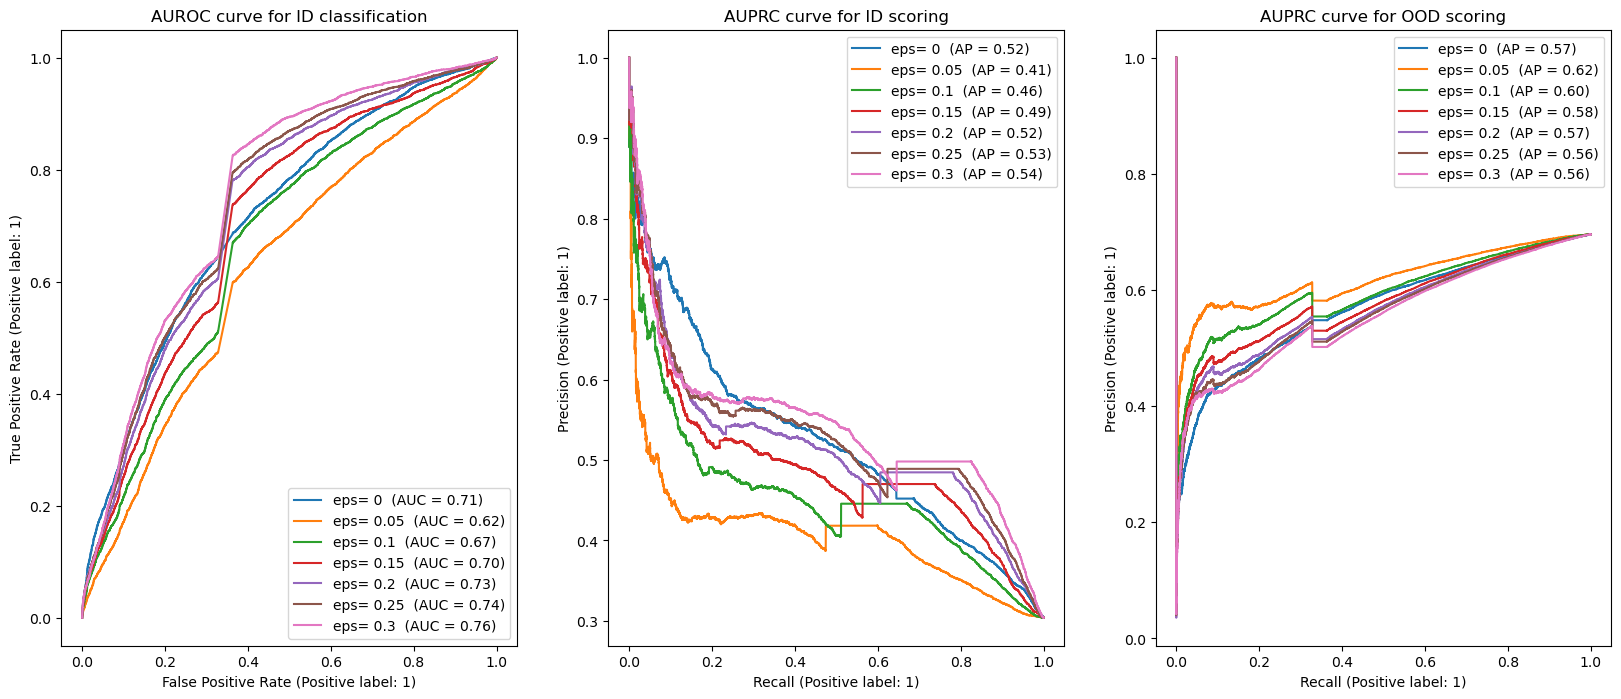

In [24]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = "./model/model.pth"
torch.manual_seed(42)

test_loader = in_data  ############

accuracies = []
examples = []

fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

for eps in epsilons:
    acc, ex, logits = test(model, device, test_loader, eps)

    logits_ID = logits
    logits_OOD = collect_logits(model, ood_data)

    roc_curve(logits_ID=logits_ID, logits_OOD=logits_OOD, eps=eps, ax=axs[0])
    pr_curve(
        logits_ID=logits_ID,
        logits_OOD=logits_OOD,
        label_positive="id",
        eps=eps,
        ax=axs[1],
    )

    pr_curve(
        logits_ID=logits_ID,
        logits_OOD=logits_OOD,
        label_positive="ood",
        eps=eps,
        ax=axs[2],
    )

    accuracies.append(acc)
    examples.append(ex)
plt.show()

ROC Curve ID e PR Curve ID: all'aumentare de valore di eps abbiamo una AUC crescente tranne nel caso eps = 0.05 dove si ha una performance inferiore

PR curve OOD: in questo caso invece la AP ha una tendenza a rimanedere nel range 57-60 tranne sempre per il caso di eps= 0.05. Questo si suggerisce che il nostro OOD detector ha delle prestazione moderate nel rilevare gli OOD a seguito di fgsm attack.


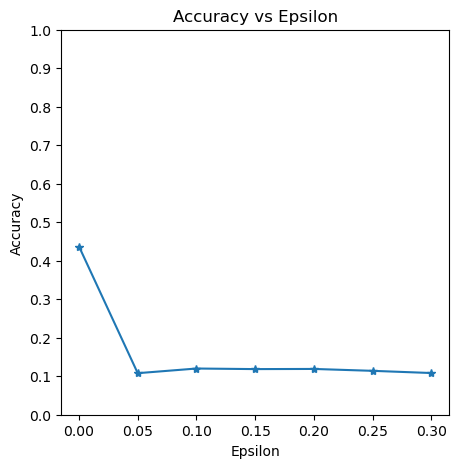

In [25]:
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Come si mostra il grafico l'accuracy del modello nella classi ID descresce all'aumentare dei valori di eps. Rimane pressochè costante per valori superiori a 0.10. Questo comportamento è in linea con quello che ci aspettavamo.


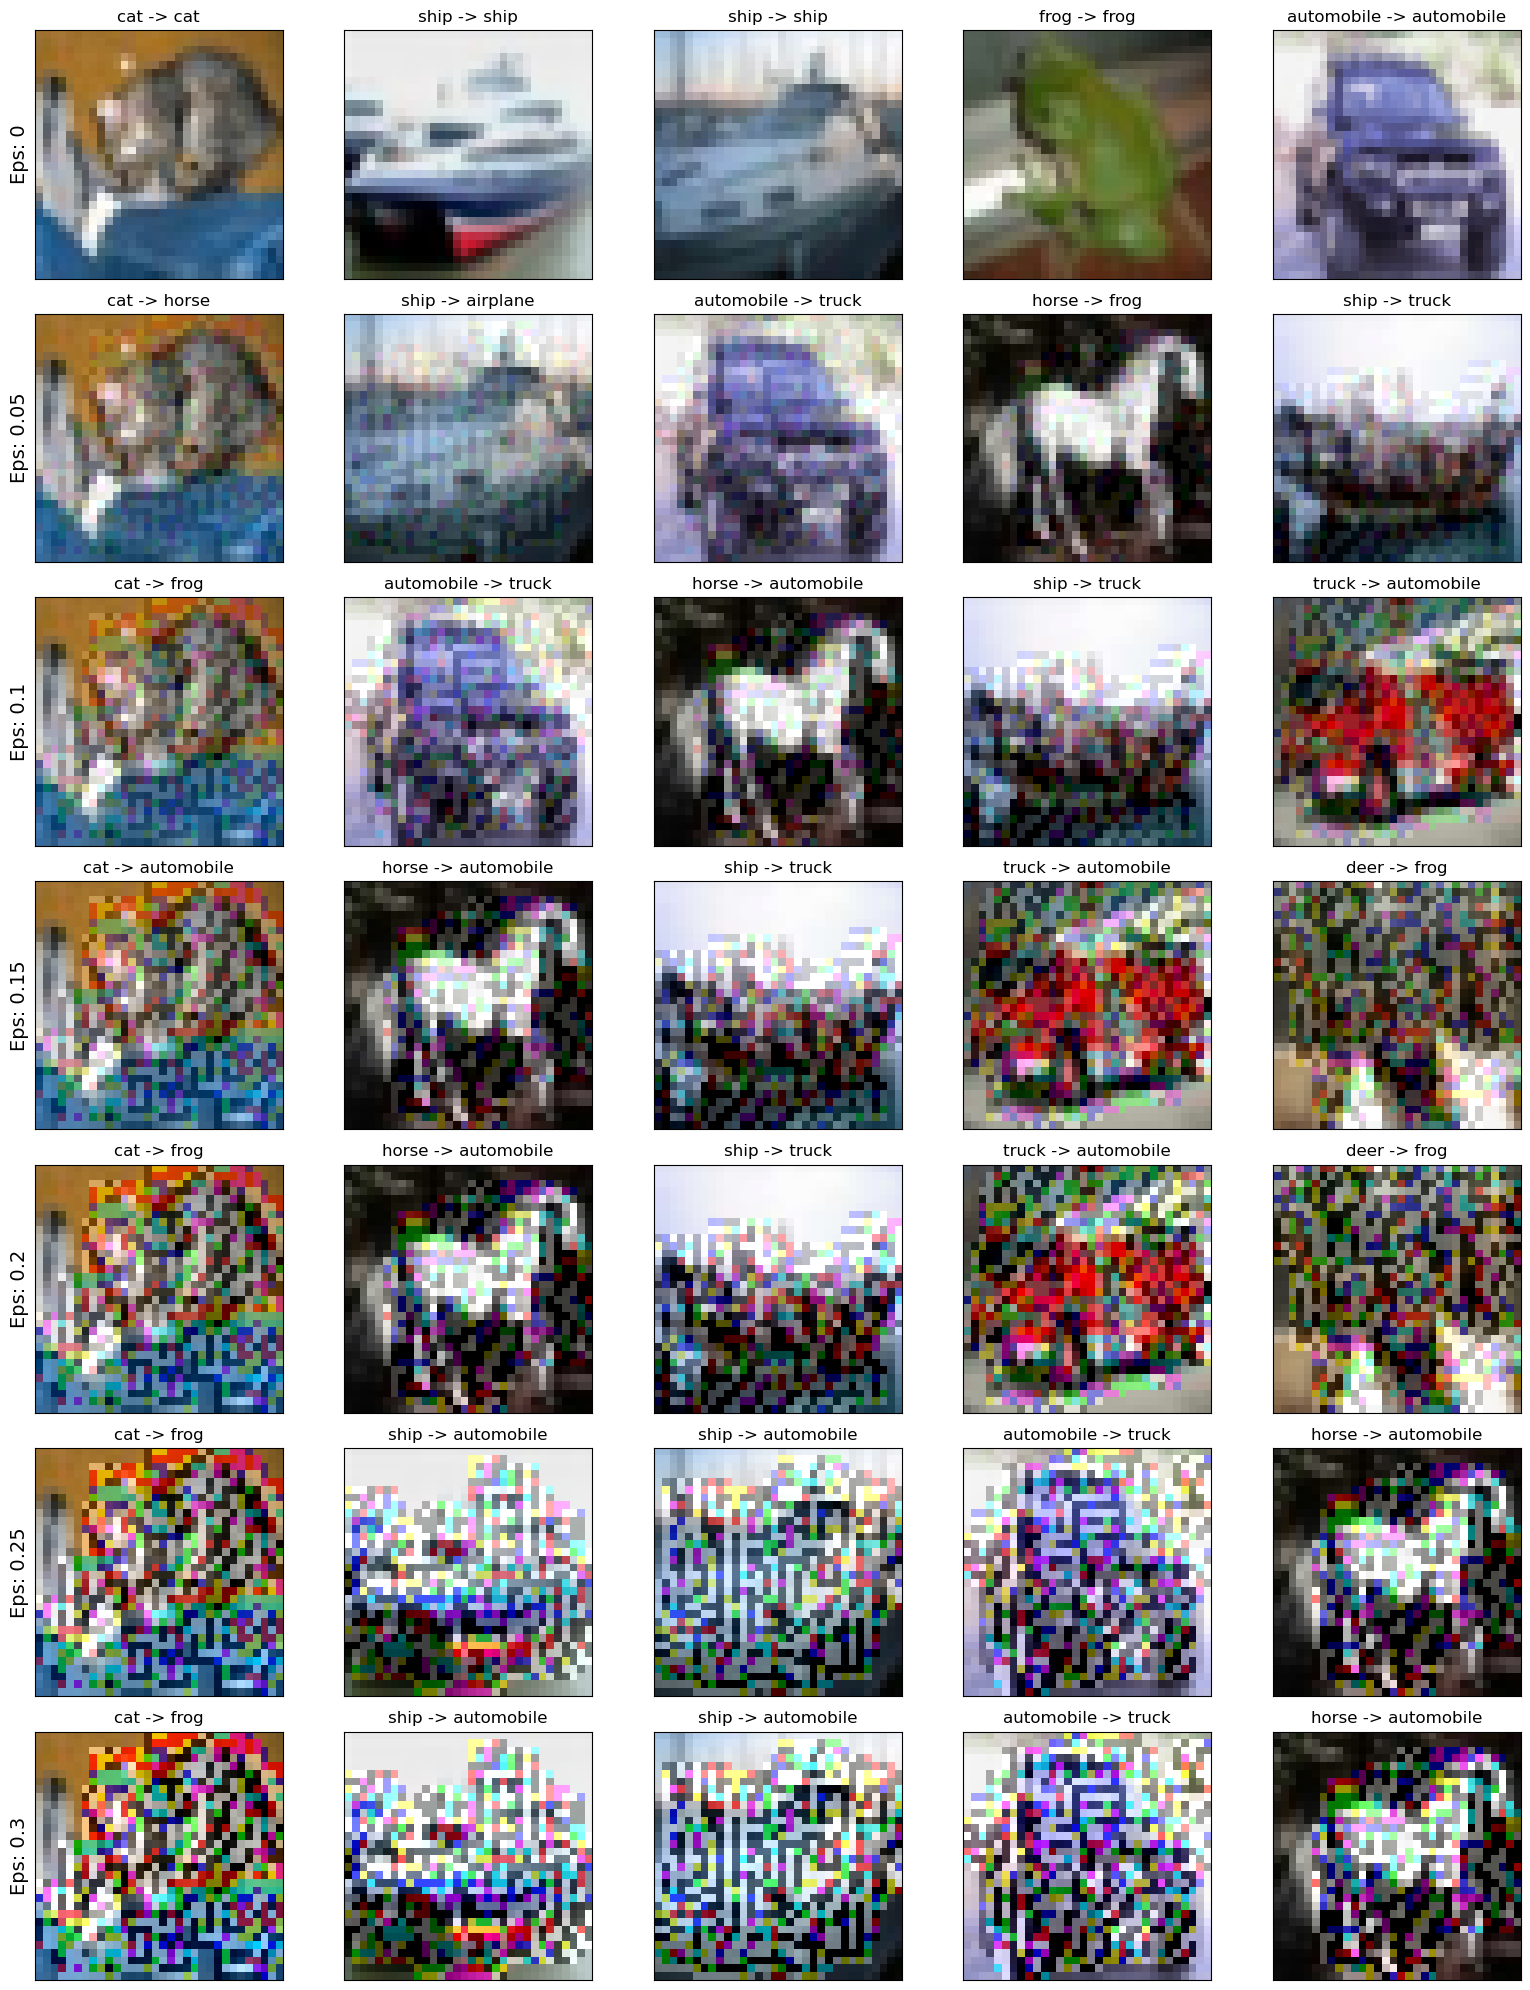

In [26]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(16, 20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title(f"{id2label[orig]} -> {id2label[adv]}")
        image_visualized = np.transpose(ex, (1, 2, 0))
        plt.imshow(image_visualized, cmap="gray")
plt.tight_layout()
plt.show()

Questo plot mostra gli esempi perturbati al variare del valore di eps e il campio di predizione a seguito della perturbazione.
Per il valore 0.05 di eps le label cambiano ma rimangono all'interno di categorie specifiche (si passa da un animale all'altro oppure da un mezzo di trasporto all'altro).
All'aumentare di eps si ha comportamenti che tendono a classificare male l'immagine. Per valori 0.25-0.3 quasi tutte le immagini vengono classificate come automobili dato il grandissimo rumore presente sull'immagine.


<span style="color: green;">

---

## Exercise 3: Wildcard

You know the drill. Pick _ONE_ of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection <span style="color: red;">(DONE)</span>

ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN

In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a _discriminator_ to your model to encourage the adversarial samples used for regularization to be more _salient_.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with _targeted_ adversarial attacks

Implement the targeted Fast Gradient Sign Method to generate adversarial samples that _imitate_ samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

</span>


## ODIN


Pipeline:

- input preprocessing: perturba l'input dei sample del test usando l'iperparaemtro eps
- dai l'input in pasto alla rete e calcola la softmax con temperatura
- calcola il valore max della probabilità (l'indice relativo al valore max è la label)
- fissa la soglia delta affinche il TPR sia 95% e confrontala con il valore max della probabilità
- trova i parametri T, eps con grid search


La funzione perturbed_image effettua la stessa identica operazione del fgsm attack ma l'argomento del gradiente contiene un logaritmo (passato successivamente).

La funzione calculate_delta ha lo scopo di trovare la treshold delta (descritto nell'articolo di ODIN) affinchè il TPR sia 95%.
odin_detector ha il semplice scopo di effettuare la predizione (ID/OOD) in base alla soglia delta.


In [27]:
def perturbed_image(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


# restores the tensors to their original scale
def denorm(
    batch,
    mean=[0.49139968, 0.48215841, 0.44653091],
    std=[0.24703223, 0.24348513, 0.26158784],
):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def odin_detector(softmax_score, threshold):
    return softmax_score > threshold


def calculate_delta(softmax_score, labels):
    _, recall, thresholds = precision_recall_curve(labels, softmax_score)
    min_recall = np.argmin(recall > 0.95)
    return thresholds[min_recall]

La cella successiva si occupa di creare un dataset di esempi perturbati e creare il relativo dataloader.


In [28]:
def create_dataset_perturbed(model, device, test_loader, epsilon, T):
    x_adv = []
    y_adv = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        output = model(data)
        max_index = torch.max(output, dim=1)[1]

        loss = F.cross_entropy(output / T, max_index)
        model.zero_grad()  # è necessario?
        loss.backward()

        data_grad = torch.log(data.grad.data)
        data_denorm = denorm(data)

        perturbed_data = perturbed_image(data_denorm, epsilon, data_grad)

        perturbed_data_normalized = transforms.Normalize(
            (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)
        )(perturbed_data)

        x_adv.append(perturbed_data_normalized)
        y_adv.append(target)
    ds = torch.utils.data.TensorDataset(
        torch.cat(x_adv, dim=0), torch.cat(y_adv, dim=0)
    )
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)

La funzione odin_score ha lo scopo di creare il dataset, raccogliere i logits dal modello, calcolare la softmax probability in base al parametro di temperatura.
Sarà fondamentale per capire quando il nostro modello è buono a classificare ID/OOD.


In [35]:
def odin_score(dl, model, T, eps):
    dl_odin = create_dataset_perturbed(model, device, dl, eps, T)
    logits = collect_logits(model, dl_odin)
    prob = torch.softmax(logits / T, dim=1)  # temperature scaling
    softmax_score = torch.max(prob, dim=1).values
    return logits.numpy(), prob.numpy(), softmax_score.numpy()


def score(dl, model, T, eps):
    return odin_score(dl, model, T, eps)

Proviamo dei valori di eps e temperatura prima di effettuare una grid search.


In [103]:
T = 1000
eps = 0.002

In [104]:
logits_ID, _, scores_ID = score(in_data, model, T, eps)
logits_OOD, _, scores_OOD = score(ood_data, model, T, eps)

Da notare che l'articolo che descrive ODIN considera gli ID come esempi positivi e gli OOD come esempi negativi


In [105]:
labels_ID = np.array([1 for _ in range(len(in_data.dataset))])
labels_OOD = np.array([0 for _ in range(len(ood_data.dataset))])
labels = np.concatenate([labels_ID, labels_OOD])
scores = np.concatenate([scores_ID, scores_OOD])

In [107]:
threshold = calculate_delta(scores, labels)
predictions = odin_detector(scores, threshold)
threshold

0.100138515

In [108]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.63      0.09      0.15     10000
           1       0.51      0.95      0.66     10000

    accuracy                           0.52     20000
   macro avg       0.57      0.52      0.41     20000
weighted avg       0.57      0.52      0.41     20000



Notare che la recall è fissa al 95%. La accuracy è del 52% quindi è piuttosto bassa. La recall invece è estremamente bassa per gli esempi negativi , circa lo 0.10. Questo ci suggerisce che il modello non è in grado di capire quali sono gli ood. Però la precisione degli OOD è maggiore di quella degli ID.


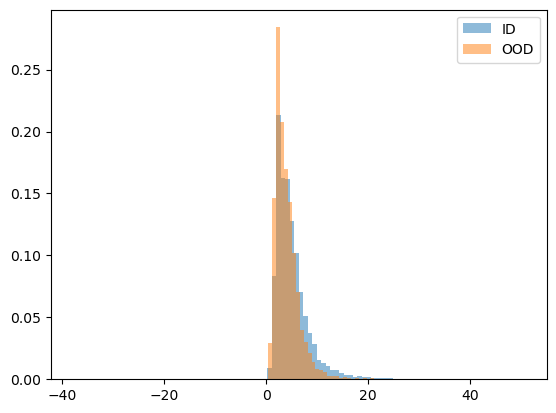

In [109]:
_ = plt.hist(logits_ID.max(1), bins=100, density=True, alpha=0.5, label="ID")
_ = plt.hist(logits_OOD.max(1), bins=100, density=True, alpha=0.5, label="OOD")
plt.legend()

Questo istrogramma continua a evidenzare di quanto il modello non sia in grado di capire gli esempi OOD nonostante abbiamo aggiunto il parametro di temperatura alla softmax e il parametro epsilon per la perturbazione.


In [110]:
print(f"AUROC: {roc_auc_score(labels, scores)}")
print(f"AP: {average_precision_score(labels, scores)}")

AUROC: 0.60699338
AP: 0.6072573424745276


In [111]:
def roc_curve(dl_in, dl_out, scores_in, scores_ood, eps, T, ax):
    labels_ID = np.array([1 for _ in range(len(dl_in.dataset))])
    labels_OOD = np.array([0 for _ in range(len(dl_out.dataset))])
    y = np.concatenate([labels_ID, labels_OOD])
    pred = np.concatenate([scores_in, scores_ood])

    if ax is not None:
        RocCurveDisplay.from_predictions(y, pred, ax=ax, name=f"eps= {eps}, T = {T} ")
        ax.set_title("AUROC curve for ID classification")
        ax.legend(loc="best")


def pr_curve(dl_in, dl_out, scores_in, scores_ood, label_positive, eps, T, ax):
    if label_positive == "id":
        labels_ID = np.array([1 for _ in range(len(dl_in.dataset))])
        labels_OOD = np.array([0 for _ in range(len(dl_out.dataset))])
        title = "AUPRC curve for ID scoring"
    if label_positive == "ood":
        labels_ID = np.array([0 for _ in range(len(dl_in.dataset))])
        labels_OOD = np.array([1 for _ in range(len(dl_out.dataset))])
        title = "AUPRC curve for OOD scoring"

    y = np.concatenate([labels_ID, labels_OOD])
    pred = np.concatenate([scores_in, scores_ood])

    if ax is not None:
        PrecisionRecallDisplay.from_predictions(
            y, pred, ax=ax, name=f"eps= {eps}, T = {T} "
        )
        ax.set_title(title)
        ax.legend(loc="best")

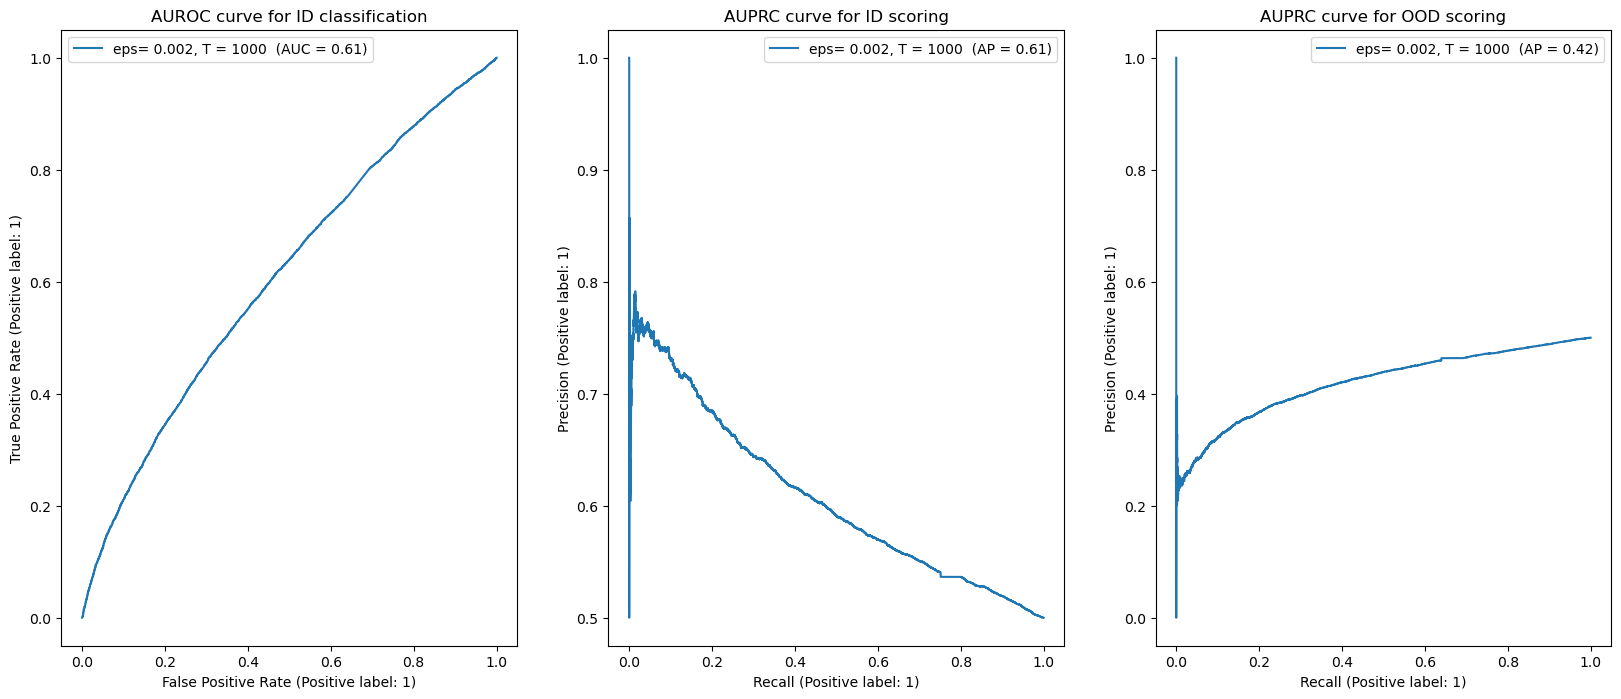

In [112]:
torch.manual_seed(42)


fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

roc_curve(in_data, ood_data, scores_ID, scores_OOD, eps=eps, T=T, ax=axs[0])
pr_curve(
    in_data,
    ood_data,
    scores_ID,
    scores_OOD,
    label_positive="id",
    eps=eps,
    T=T,
    ax=axs[1],
)

pr_curve(
    in_data,
    ood_data,
    scores_ID,
    scores_OOD,
    label_positive="ood",
    eps=eps,
    T=T,
    ax=axs[2],
)

plt.show()

La AUROC e la AUPRC sono entrambi a 0.61 per gli ID example e si tratta di una performance moderata. La AUPRC invece è sempre sotto il 50% (0.42) e questo è in linea con gli esperimenti sopra.


Adesso scegliamo dei range per i parametri epsilon e temperature e eseguiamo la grid search considerando come obbiettivo la massimizzazione della AUROC.


In [92]:
labels_ID = np.array([0 for _ in range(len(in_data.dataset))])
labels_OOD = np.array([1 for _ in range(len(ood_data.dataset))])
y = np.concatenate([labels_ID, labels_OOD])

best_roc = -float("inf")
best_params = None

for T in np.linspace(100, 10000, 5):
    for eps in np.linspace(0.00002, 0.02, 5):
        _, _, scores_ID = odin_score(in_data, model, T, eps)
        _, _, scores_OOD = odin_score(ood_data, model, T, eps)
        scores = np.concatenate([scores_ID, scores_OOD])

        roc = roc_auc_score(labels, scores)

        if roc > best_roc:
            best_roc = roc
            best_params = [T, eps]
            print(f"T: {T:.1f} | eps: {eps:.5f} | roc: {roc:.3f} --> BEST")
        else:
            print(f"T: {T:.1f} | eps: {eps:.5f} | roc: {roc:.3f}")

T: 100.0 | eps: 0.00002 | roc: 0.388 --> BEST
T: 100.0 | eps: 0.00502 | roc: 0.398 --> BEST
T: 100.0 | eps: 0.01001 | roc: 0.402 --> BEST
T: 100.0 | eps: 0.01501 | roc: 0.404 --> BEST
T: 100.0 | eps: 0.02000 | roc: 0.405 --> BEST
T: 2575.0 | eps: 0.00002 | roc: 0.388
T: 2575.0 | eps: 0.00502 | roc: 0.398
T: 2575.0 | eps: 0.01001 | roc: 0.403
T: 2575.0 | eps: 0.01501 | roc: 0.404
T: 2575.0 | eps: 0.02000 | roc: 0.405 --> BEST
T: 5050.0 | eps: 0.00002 | roc: 0.388
T: 5050.0 | eps: 0.00502 | roc: 0.398
T: 5050.0 | eps: 0.01001 | roc: 0.403
T: 5050.0 | eps: 0.01501 | roc: 0.404
T: 5050.0 | eps: 0.02000 | roc: 0.405
T: 7525.0 | eps: 0.00002 | roc: 0.388
T: 7525.0 | eps: 0.00502 | roc: 0.398
T: 7525.0 | eps: 0.01001 | roc: 0.403
T: 7525.0 | eps: 0.01501 | roc: 0.404
T: 7525.0 | eps: 0.02000 | roc: 0.405
T: 10000.0 | eps: 0.00002 | roc: 0.388
T: 10000.0 | eps: 0.00502 | roc: 0.398
T: 10000.0 | eps: 0.01001 | roc: 0.403
T: 10000.0 | eps: 0.01501 | roc: 0.404
T: 10000.0 | eps: 0.02000 | roc: 0.

- T: 100.0 | eps: 0.00002 | roc: 0.388 --> BEST
- T: 100.0 | eps: 0.00502 | roc: 0.398 --> BEST
- T: 100.0 | eps: 0.01001 | roc: 0.402 --> BEST
- T: 100.0 | eps: 0.01501 | roc: 0.404 --> BEST
- T: 100.0 | eps: 0.02000 | roc: 0.405 --> BEST
- T: 2575.0 | eps: 0.00002 | roc: 0.388
- T: 2575.0 | eps: 0.00502 | roc: 0.398
- T: 2575.0 | eps: 0.01001 | roc: 0.403
- T: 2575.0 | eps: 0.01501 | roc: 0.404
- T: 2575.0 | eps: 0.02000 | roc: 0.405 --> BEST
- T: 5050.0 | eps: 0.00002 | roc: 0.388
- T: 5050.0 | eps: 0.00502 | roc: 0.398
- T: 5050.0 | eps: 0.01001 | roc: 0.403
- T: 5050.0 | eps: 0.01501 | roc: 0.404
- T: 5050.0 | eps: 0.02000 | roc: 0.405
- T: 7525.0 | eps: 0.00002 | roc: 0.388
- T: 7525.0 | eps: 0.00502 | roc: 0.398
- T: 7525.0 | eps: 0.01001 | roc: 0.403
- T: 7525.0 | eps: 0.01501 | roc: 0.404
- T: 7525.0 | eps: 0.02000 | roc: 0.405
- T: 10000.0 | eps: 0.00002 | roc: 0.388
- T: 10000.0 | eps: 0.00502 | roc: 0.398
- T: 10000.0 | eps: 0.01001 | roc: 0.403
- T: 10000.0 | eps: 0.01501 | roc: 0.404
- T: 10000.0 | eps: 0.02000 | roc: 0.405


In [113]:
T = best_params[0]
esp = best_params[1]
print(f"Best T: {T}, Best esp: {esp}")

Best T: 2575.0, Best esp: 0.02


In [ ]:
T = 2575.0
esp = 0.02
print(f"Best T: {T}, Best esp: {esp}")

In [95]:
_, _, scores_ID = score(in_data, model, T, eps)
_, _, scores_OOD = score(ood_data, model, T, eps)

In [115]:
labels_ID = np.array([0 for _ in range(len(in_data.dataset))])
labels_OOD = np.array([1 for _ in range(len(ood_data.dataset))])
labels = np.concatenate([labels_ID, labels_OOD])

scores = np.concatenate([scores_ID, scores_OOD])
threshold = calculate_delta(scores, labels)
predictions = odin_detector(scores, threshold)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.37      0.03      0.06     10000
           1       0.49      0.95      0.65     10000

    accuracy                           0.49     20000
   macro avg       0.43      0.49      0.35     20000
weighted avg       0.43      0.49      0.35     20000



Stessi risultati nella media nonstante l'uso dei parametri ottimi.


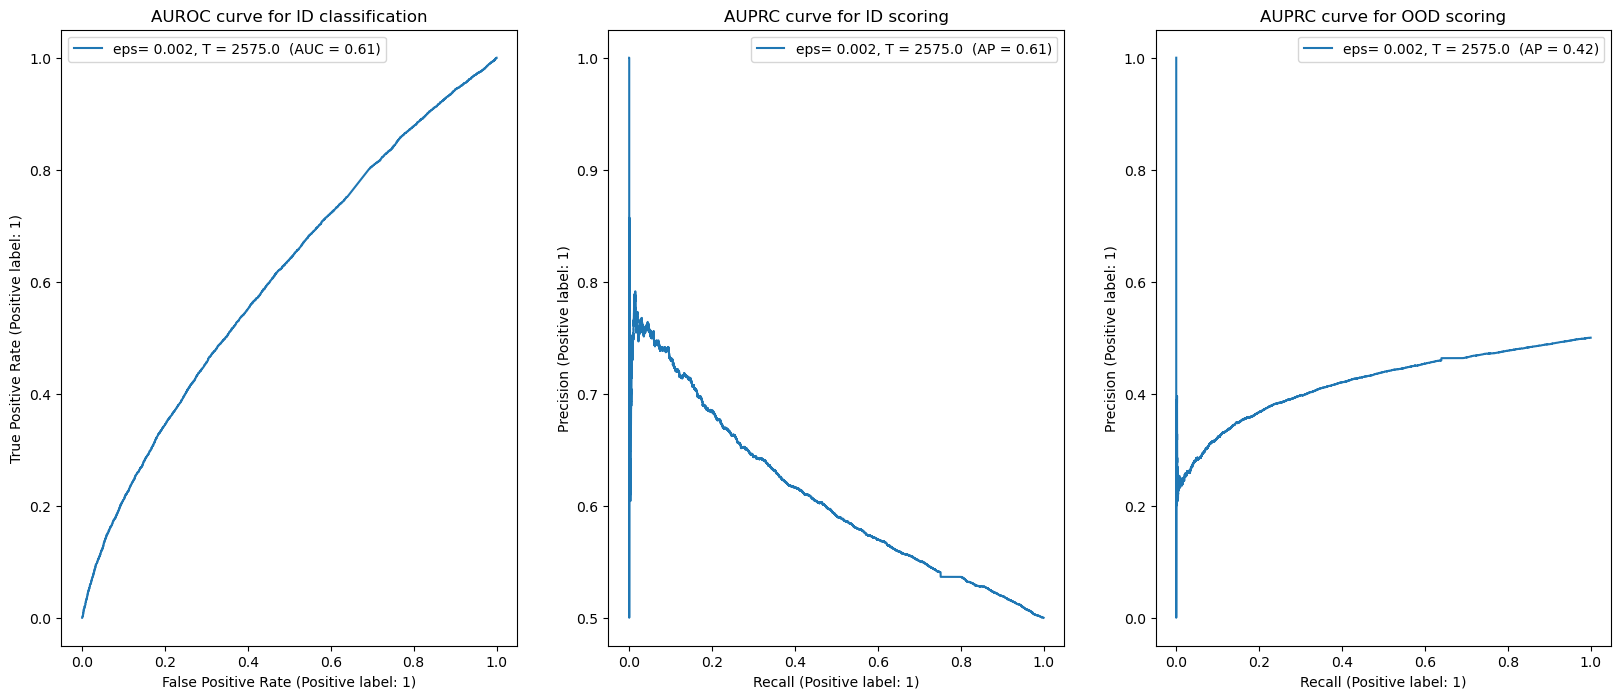

In [116]:
torch.manual_seed(42)


fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

roc_curve(in_data, ood_data, scores_ID, scores_OOD, eps=eps, T=T, ax=axs[0])
pr_curve(
    in_data,
    ood_data,
    scores_ID,
    scores_OOD,
    label_positive="id",
    eps=eps,
    T=T,
    ax=axs[1],
)

pr_curve(
    in_data,
    ood_data,
    scores_ID,
    scores_OOD,
    label_positive="ood",
    eps=eps,
    T=T,
    ax=axs[2],
)

plt.show()